# Raincoat: Take home exercise

## Aim

1. Demonstrate how to combine multiple datasets of Soil Moisture, that is commonly used as a data indices to describe agricultural processes through remote sensing or modeling. The data to combine are from two different souces, the ESA CCI Soil Moisture and ERA5-Land soil moisture dataset :

        -Create a combined gap free soil moisture product
        -Consider only the top level SM
        -Merge the two datasets together

2. Suppose you have the yield data for various crops in a country for the last 20 years, how would
you create a yield prediction algorithm without in-situ data? What satellite, data sources, models,
AI models, statistics would you use? Please describe how your algorithm would work.

For the exercise I will first demonstrate how I downloaded the data, asses the data structure and the plot a map to visualise the differences between the satelite images.

Finally, I'll explain how I would build an algorithm capable of predicting the yield of various crops without in-situ data.

# Import necessary libraries

In [6]:
import os
import requests
from ftplib import FTP
import netCDF4 as nc
from netCDF4 import Dataset,num2date
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.util import add_cyclic_point
import matplotlib.pyplot as plt
plt.rcParams['mathtext.default'] = 'regular'
import numpy as np
import cdsapi
import zipfile
from IPython.display import Image
from IPython.display import display
import xarray as xr
import geopandas
import rioxarray as rio
from shapely.geometry import mapping
from mpl_toolkits.basemap import Basemap
import PIL
from matplotlib.colors import Normalize
from scipy.interpolate import griddata

## Data ESA-CCI

The ESA-CCI soil moisture combined product provides global daily volumetric soil moisture data at a spatial resolution of 0.25∘ from 1978 to 2019. It was created by merging multiple scatterometer and radiometer soil moisture products (from the AMI-WS, ASCAT, SMMR, SSM/I, TMI, AMSR-E, WindSat, AMSR2, SMOS and SMAP satellites) and covers the period from 1978 to 2022 (Dorigo et al., 2017; Gruber et al., 2017, 2019).

In [8]:
#period = list(range(20,2022))µ
#list_year = [str(x) for x in period]
list_year = ["2018"]
#Home directory
dirHome = "C:/Users/frenc/Desktop/SK enterprise/raincoat-takehome-science-main/"
#Data directory
dirData = dirHome + 'data/'
dirOutput = dirHome + 'output/'
os.chdir(dirHome)

### FTP conection to CEDA archive data

In [74]:

#Set local director to dowload 
dirName = 'C:/Users/frenc/Desktop/SK enterprise/raincoat-takehome-science-main/data/cerda'
#create a loop for downloading data fror eahc year
for year in list_year:
     #Connnect to ftp port 
    ftp = FTP('ftp.ceda.ac.uk')
    #Enter login and password
    ftp.login(user='skarasiewicz', passwd="Nej3L'%!-ltX")
    #Creating a string for direcotry for the year to stire the data
    dirName_year = 'C:/Users/frenc/Desktop/SK enterprise/raincoat-takehome-science-main/data/cerda' + year
    # Making the string into a path
    dirName_data =  os.path.join(dirName_year)
    #Create directory only if it doesn't exist
    try:
        os.mkdir(dirName_data)
    except OSError as error: 
        print(error) 
    #Changing the directory
    os.chdir(dirName_data)
    #Creating a string with the directory of the data
    cwd_year = 'neodc/esacci/soil_moisture/data/daily_files/COMBINED/v08.1/' + year
    #Go into the data directory
    ftp.cwd(cwd_year)
    #Extract list of files names
    filenames = ftp.nlst()
    #For each filename
    for filename in filenames:
        #Ceating a file    
        with open( filename, 'wb' ) as file :
            ftp.retrbinary('RETR %s' % filename, file.write)
            
            file.close()
            
    ftp.quit()
    
#reset the working directory
os.chdir(dirHome)

### Data structure

In [34]:

# Open the NetCDF file
file_path = 'C:/Users/frenc/Desktop/SK enterprise/raincoat-takehome-science-main/data/cerda2018/ESACCI-SOILMOISTURE-L3S-SSMV-COMBINED-20181001000000-fv08.1.nc'  # Replace 'your_file.nc' with the path to your NetCDF file
data = nc.Dataset(file_path, 'r')

# Display the dimensions available in the file
print("Dimensions:")
for dim in data.dimensions.values():
    print(dim)

# Display the variables available in the file
print("\nVariables:")
for var in data.variables.values():
    print(var)


Dimensions:
<class 'netCDF4._netCDF4.Dimension'>: name = 'time', size = 1
<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 720
<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 1440

Variables:
<class 'netCDF4._netCDF4.Variable'>
uint16 time(time)
    long_name: time stamp
    standard_name: time
    units: days since 1970-01-01T00:00:00+00:00
    calendar: proleptic_gregorian
unlimited dimensions: 
current shape = (1,)
filling on, default _FillValue of 65535 used
<class 'netCDF4._netCDF4.Variable'>
float64 lat(lat)
    _FillValue: nan
    standard_name: latitude
    units: degrees_north
    valid_range: [-90.  90.]
    _CoordinateAxisType: Lat
unlimited dimensions: 
current shape = (720,)
filling on
<class 'netCDF4._netCDF4.Variable'>
float64 lon(lon)
    _FillValue: nan
    standard_name: longitude
    units: degrees_east
    valid_range: [-180.  180.]
    _CoordinateAxisType: Lon
unlimited dimensions: 
current shape = (1440,)
filling on
<class 'netCDF4._netCDF4.Va

By looking into one nc file, we can see that the variables of interest for the soil moisture is "sm". 

In [35]:
# Extract data from a variable
desired_variable = data.variables['sm']  # Replace 'variable_name' with the name of the variable you want to extract
variable_data = desired_variable[:]  # This will extract the entire data from the variable

# Close the NetCDF file
data.close()

In [36]:
variable_data

masked_array(
  data=[[[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --]]],
  mask=[[[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True]]],
  fill_value=-9999.0,
  dtype=float32)

The variable is a mask array which can be unmask with following procedure

In [42]:
variable_data[~variable_data.mask]

masked_array(data=[0.28038286122089284, 0.26658744028209685,
                   0.2599068749926527, ..., 0.3071104839880511,
                   0.3017595978252378, 0.3024190757791717],
             mask=[False, False, False, ..., False, False, False],
       fill_value=-32767)

### Map

C:\Users\frenc\anaconda3\Lib\site-packages\cartopy\mpl\geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contourf(*args, **kwargs)


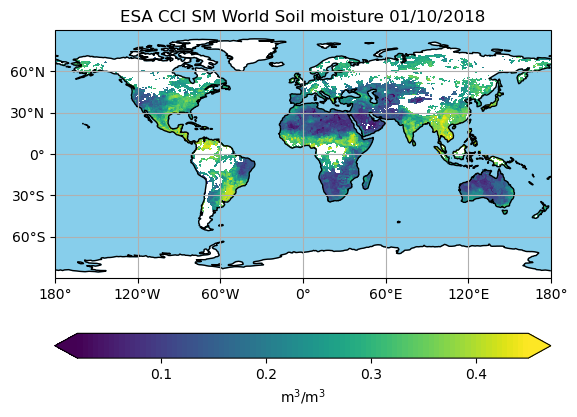

In [56]:
file =  'C:/Users/frenc/Desktop/SK enterprise/raincoat-takehome-science-main/data/cerda2018/ESACCI-SOILMOISTURE-L3S-SSMV-COMBINED-20181001000000-fv08.1.nc'
nc_pvFile = Dataset(file,'r')
lats = nc_pvFile.variables['lat'][:]  # extract/copy the data
lons = nc_pvFile.variables['lon'][:]
lats = lats[:].squeeze()
lons = lons[:].squeeze()

smPlot = nc_pvFile.variables['sm'][:]
smPlot = smPlot[0,:,:]
sm = smPlot[~smPlot.mask]



ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
clevs = np.arange(min(sm.flatten()),max(sm.flatten())*1000,1).round
shear_fill = ax1.contourf(lons,lats,smPlot,clevs,
                      transform=ccrs.PlateCarree(),cmap=plt.get_cmap('viridis'),
                                                                      linewidth=(10,),levels=100,extend='both')

ax1.add_feature(cfeature.OCEAN,color='#87CEEB')

ax1.coastlines()
ax1.gridlines()
ax1.set_xticks([-180, -120,-60,0,60,120,180], crs=ccrs.PlateCarree())
ax1.set_yticks([-60,-30,0,30,60], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)
cbar = plt.colorbar(shear_fill, orientation='horizontal', ticks= [0.1,0.2,0.3,0.4], label="m$^3$/m$^3$")
plt.title('ESA CCI SM World Soil moisture 01/10/2018', fontsize=12)
plt.savefig('output/soil_moistur_world_esa.png')
nc_pvFile.close()

So for each daily netcdf file, we can plot the estimate of the world soil moisture. In order to merge this data to the other, it preferable to have more information on the other sattelite image source.

## Data ERA5-Land

ERA5-Land (Muñoz-Sabater et al., 2021) is the reanalysis climatic database provided by the European Centre for Medium-Range Weather Forecast (ECMWF). The soil moisture and the rest of the reanalysis variables at a spatial resolution of 9 × 9 km (approxiamtely 0.1°)  are generated by assimilating observations into the physical modelling data of the Integrated Forecasting System (IFS) of ECMWF. The upper three soil moisture layers of the four ERA5-Land layers are adopted as the root zone soil moisture (RZSM) from 0 to 100 cm depth. Only the first layer will be considered.

### API connection to CDS Climate Copernicus

The cdsapi offers the possibility to download data effciliently thought python with USERID and KEY after registreing on the copernicus website by creating a file format".cdsapirc" containing the following lines:

url: https://cds.climate.copernicus.eu/api/v2

key: USERID:KEY

In [ ]:
c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-land',
    {
        'variable': 'volumetric_soil_water_layer_1',
        'year': '2018',
        'month': '10',
        'day': '01',
        'time': '12:00',
        'format': 'netcdf.zip',
    },
    'C:/Users/frenc/Desktop/SK enterprise/raincoat-takehome-science-main/data/copernicus/download.netcdf.zip')

with zipfile.ZipFile("C:/Users/frenc/Desktop/SK enterprise/raincoat-takehome-science-main/data/copernicus/download.netcdf.zip","r") as zip_ref:
    zip_ref.extractall("C:/Users/frenc/Desktop/SK enterprise/raincoat-takehome-science-main/data/copernicus/")

2023-11-16 16:11:08,773 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-land
2023-11-16 16:11:29,834 WARNING Connection error: [HTTPSConnectionPool(host='cds.climate.copernicus.eu', port=443): Max retries exceeded with url: /api/v2/resources/reanalysis-era5-land (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x000001C2BA4993D0>, 'Connection to cds.climate.copernicus.eu timed out. (connect timeout=60)'))]. Attempt 1 of 500.
2023-11-16 16:11:29,835 WARNING Retrying in 120 seconds


In [69]:
os.getcwd()

'C:\\Users\\frenc\\Desktop\\SK enterprise\\raincoat-takehome-science-main'

### Data stucture

In [45]:
# Open the NetCDF file
file_path = 'C:/Users/frenc/Desktop/SK enterprise/raincoat-takehome-science-main/data/copernicus/data.nc'  # Replace 'your_file.nc' with the path to your NetCDF file
data = nc.Dataset(file_path, 'r')

# Display the dimensions available in the file
print("Dimensions:")
for dim in data.dimensions.values():
    print(dim)

# Display the variables available in the file
print("\nVariables:")
for var in data.variables.values():
    print(var)

# Extract data from a variable
desired_variable = data.variables['swvl1']  # Replace 'variable_name' with the name of the variable you want to extract
variable_data = desired_variable[:]  # This will extract the entire data from the variable

# Close the NetCDF file
data.close()

Dimensions:
<class 'netCDF4._netCDF4.Dimension'>: name = 'longitude', size = 3600
<class 'netCDF4._netCDF4.Dimension'>: name = 'latitude', size = 1801
<class 'netCDF4._netCDF4.Dimension'>: name = 'time', size = 1

Variables:
<class 'netCDF4._netCDF4.Variable'>
float32 longitude(longitude)
    units: degrees_east
    long_name: longitude
unlimited dimensions: 
current shape = (3600,)
filling on, default _FillValue of 9.969209968386869e+36 used
<class 'netCDF4._netCDF4.Variable'>
float32 latitude(latitude)
    units: degrees_north
    long_name: latitude
unlimited dimensions: 
current shape = (1801,)
filling on, default _FillValue of 9.969209968386869e+36 used
<class 'netCDF4._netCDF4.Variable'>
int32 time(time)
    units: hours since 1900-01-01 00:00:00.0
    long_name: time
    calendar: gregorian
unlimited dimensions: 
current shape = (1,)
filling on, default _FillValue of -2147483647 used
<class 'netCDF4._netCDF4.Variable'>
int16 swvl1(time, latitude, longitude)
    scale_factor: 1.1

By looking into one nc file, we can see that the variables of interest for the soil moisture is "swvl1". 

In [65]:
variable_data

masked_array(
  data=[[[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [0.15905373525730834, 0.15893821104518072, 0.15883423925426587,
          ..., 0.15957359421188264, 0.15941186031490398,
          0.15922702157549978],
         [0.158245065772415, 0.15814109398150014, 0.15803712219058527,
          ..., 0.1588573440966914, 0.15866095293607443,
          0.15845300935424472],
         [0.20609519443567553, 0.20609519443567553, 0.20609519443567553,
          ..., 0.20609519443567553, 0.20609519443567553,
          0.20609519443567553]]],
  mask=[[[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]],
  f

As previoulsy mentionned the array can be unmask with the following procedure.

In [67]:
variable_data[~variable_data.mask]

masked_array(data=[0.17816143994321684, 0.17816143994321684,
                   0.17816143994321684, ..., 0.20609519443567553,
                   0.20609519443567553, 0.20609519443567553],
             mask=[False, False, False, ..., False, False, False],
       fill_value=-32767)

### Map

C:\Users\frenc\anaconda3\Lib\site-packages\cartopy\mpl\geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contourf(*args, **kwargs)


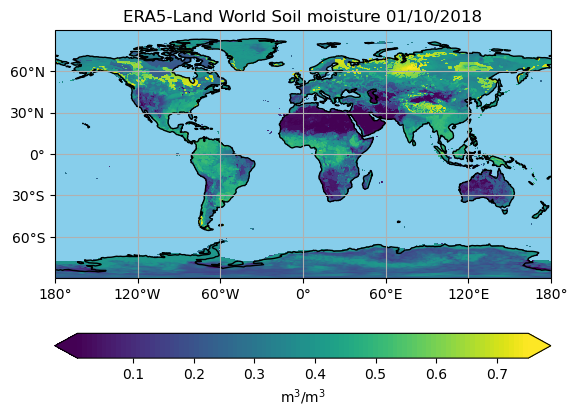

In [57]:

file =  'C:/Users/frenc/Desktop/SK enterprise/raincoat-takehome-science-main/data/copernicus/data.nc'
nc_pvFile = Dataset(file,'r')
lats = nc_pvFile.variables['latitude'][:]  # extract/copy the data
lons = nc_pvFile.variables['longitude'][:]
lats = lats[:].squeeze()
lons = lons[:].squeeze()

smPlot = nc_pvFile.variables['swvl1'][:]
smPlot = smPlot[0,:,:]
sm = smPlot[~smPlot.mask]



ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
clevs = np.arange(min(sm.flatten()),max(sm.flatten())*1000,1).round
shear_fill = ax1.contourf(lons,lats,smPlot,clevs,
                      transform=ccrs.PlateCarree(),cmap=plt.get_cmap('viridis'),
                                                                      linewidth=(10,),levels=100,extend='both')

ax1.add_feature(cfeature.OCEAN,color='#87CEEB')

ax1.coastlines()
ax1.gridlines()
ax1.set_xticks([-180, -120,-60,0,60,120,180], crs=ccrs.PlateCarree())
ax1.set_yticks([-60,-30,0,30,60], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)
cbar = plt.colorbar(shear_fill, orientation='horizontal', ticks= [0.1,0.2,0.3,0.4, 0.5, 0.6,0.7], label="m$^3$/m$^3$")
plt.title('ERA5-Land World Soil moisture 01/10/2018', fontsize=12)
plt.savefig('output/soil_moistur_world_cop.png')
nc_pvFile.close()

# Comparaison

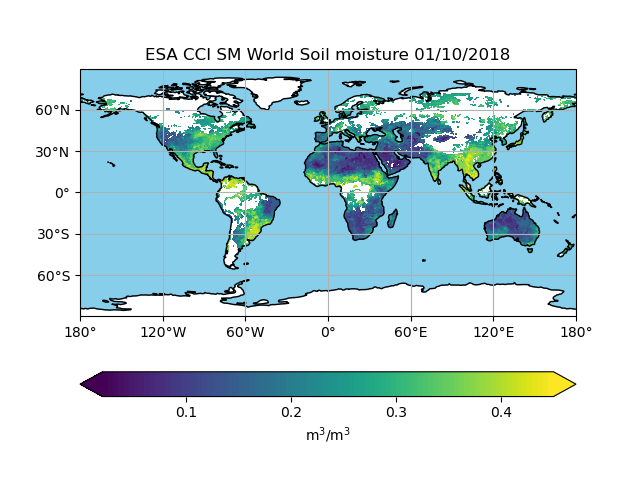

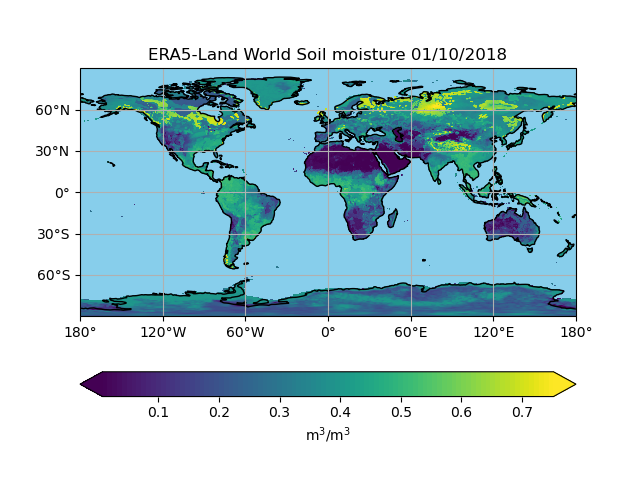

In [63]:
x = Image(filename='output/soil_moistur_world_esa.png') 
y = Image(filename='output/soil_moistur_world_cop.png') 
display(x, y)

The comparaison between the maps reveals that the data extrated by the ERA5-LAND satelite imagery is more complete and with a higher resolution extracted than the one from the ESA CCI. Also the range of value for soil moisture is higher for ERA5-LAND (0 to 0.8) than ESA CCI (0 to 0.5). 

Before combining the two datasets, I decided to reduced the datasets from global to the country of Costa Rica. A 'box' was created around the country in order to create the bounds of the data. Also I will reduce the time-series, the month of october 2018.

# Reduction of data

## Data ESA-CCI data reduction

First combined all the data from the month of october

In [4]:
DS = xr.open_mfdataset(os.path.join(dirData + "cerda2018/ESACCI-SOILMOISTURE-L3S-SSMV-COMBINED-201810*.nc"))
DS
DS.to_netcdf(path=dirData + "cerda2018/october2018.nc")
DS.close()

C:\Users\frenc\anaconda3\Lib\site-packages\xarray\coding\times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
C:\Users\frenc\anaconda3\Lib\site-packages\xarray\coding\times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
C:\Users\frenc\anaconda3\Lib\site-packages\xarray\coding\times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
C:\Users\frenc\anaconda3\Lib\site-packages\xarray\coding\times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
C:\Users\frenc\anaconda3\Lib\site-packages\xarray\coding\times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


Reducing the data in order to only have the Costa Rica "box".

In [6]:
os.chdir(dirData + "cerda2018/")
DS = xr.open_dataset('october2018.nc')
DS_clipped = DS.sel(lon=slice(-85.98, -82.27), lat=slice(11.31, 7.8))  

DS.close()
DS_clipped.to_netcdf(path=dirData + "cerda2018/costa_rica_october2018.nc")
DS_clipped.close()

## Map

C:\Users\frenc\anaconda3\Lib\site-packages\cartopy\mpl\geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contourf(*args, **kwargs)
C:\Users\frenc\anaconda3\Lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
C:\Users\frenc\anaconda3\Lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
C:\Users\frenc\anaconda3\Lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
C:\Users\frenc\anaconda3\Lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will hav

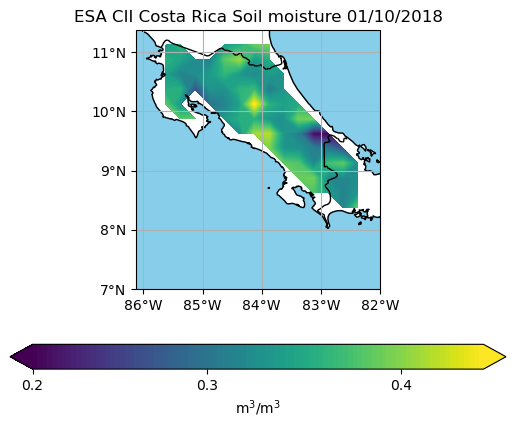

In [134]:
file =  'C:/Users/frenc/Desktop/SK enterprise/raincoat-takehome-science-main/data/cerda2018/costa_rica_october2018.nc'
nc_pvFile = Dataset(file,'r')
lats = nc_pvFile.variables['lat'][:]  # extract/copy the data
lons = nc_pvFile.variables['lon'][:]
lats = lats[:].squeeze()
lons = lons[:].squeeze()

smPlot = nc_pvFile.variables['sm'][:]
smPlot = smPlot[0,:,:]
sm = smPlot[~smPlot.mask]

ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([min(lons)-0.25,max(lons)+0.25,min(lats)-0.25,max(lats)+0.25], crs=ccrs.PlateCarree())
clevs = np.arange(min(sm.flatten()),max(sm.flatten())*1000,1).round
shear_fill = ax1.contourf(lons,lats,smPlot,clevs,
                      transform=ccrs.PlateCarree(),cmap=plt.get_cmap('viridis'),
                                                                      linewidth=(10,),levels=100,extend='both')
ax1.add_feature(cfeature.OCEAN,color='#87CEEB')
ax1.add_feature(cfeature.BORDERS,color='black')

ax1.gridlines()
ax1.coastlines()
ax1.set_xticks([-86,-85,-84,-83, -82], crs=ccrs.PlateCarree())
ax1.set_yticks([7,8,9,10,11], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)
cbar = plt.colorbar(shear_fill, orientation='horizontal',  ticks= [0.2,0.3,0.4], label="m$^3$/m$^3$")
plt.title('ESA CII Costa Rica Soil moisture 01/10/2018', fontsize=12)
os.chdir(dirOutput)
plt.savefig('costa_rica_soil_moistur_esa.png')
nc_pvFile.close()

## Data ESA-CCI October download

In [154]:
c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-land',
    {
        'variable': 'volumetric_soil_water_layer_1',
        'year': '2018',
        'month': '10',
        'day': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
            '13', '14', '15',
            '16', '17', '18',
            '19', '20', '21',
            '22', '23', '24',
            '25', '26', '27',
            '28', '29', '30',
            '31',
        ],
        'time': '12:00',
        'format': 'netcdf.zip',
        'area': [
            11.31, -85.98, 7.8,
            -82.27,
        ],
    },
    'C:/Users/frenc/Desktop/SK enterprise/raincoat-takehome-science-main/data/copernicus/download.netcdf.zip')

with zipfile.ZipFile("C:/Users/frenc/Desktop/SK enterprise/raincoat-takehome-science-main/data/copernicus/download.netcdf.zip","r") as zip_ref:
    zip_ref.extractall("C:/Users/frenc/Desktop/SK enterprise/raincoat-takehome-science-main/data/copernicus/costa_rica")

2023-11-17 16:22:17,394 INFO Welcome to the CDS
2023-11-17 16:22:17,394 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-land
2023-11-17 16:22:17,542 INFO Request is completed
2023-11-17 16:22:17,544 INFO Downloading https://download-0010-clone.copernicus-climate.eu/cache-compute-0010/cache/data8/adaptor.mars.internal-1700217184.886201-2973-4-8632839d-b8c0-41d1-9e35-dc65bf5e49e8.zip to C:/Users/frenc/Desktop/SK enterprise/raincoat-takehome-science-main/data/copernicus/download.netcdf.zip (36.9K)
2023-11-17 16:22:18,428 INFO Download rate 41.8K/s 


C:\Users\frenc\anaconda3\Lib\site-packages\cartopy\mpl\geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contourf(*args, **kwargs)
C:\Users\frenc\anaconda3\Lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
C:\Users\frenc\anaconda3\Lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
C:\Users\frenc\anaconda3\Lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
C:\Users\frenc\anaconda3\Lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will hav

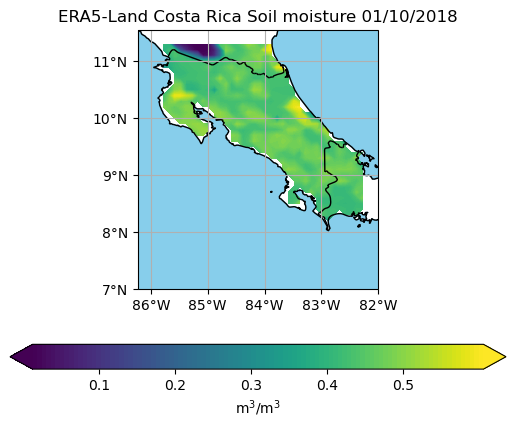

In [155]:
file =  'C:/Users/frenc/Desktop/SK enterprise/raincoat-takehome-science-main/data/copernicus/costa_rica/data.nc'
nc_pvFile = Dataset(file,'r')
lats = nc_pvFile.variables['latitude'][:]  # extract/copy the data
lons = nc_pvFile.variables['longitude'][:]
lats = lats[:].squeeze()
lons = lons[:].squeeze()

swvl1Plot = nc_pvFile.variables['swvl1'][:]
swvl1Plot = swvl1Plot[0,:,:]
swvl1 = swvl1Plot[~swvl1Plot.mask]


ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([min(lons)-0.25,max(lons)+0.25,min(lats)-0.25,max(lats)+0.25], crs=ccrs.PlateCarree())
clevs = np.arange(min(swvl1.flatten()),max(swvl1.flatten())*1000,1).round
shear_fill = ax1.contourf(lons,lats,swvl1Plot,clevs,
                      transform=ccrs.PlateCarree(),cmap=plt.get_cmap('viridis'),
                                                                      linewidth=(10,),levels=100,extend='both')
ax1.add_feature(cfeature.OCEAN,color='#87CEEB')
ax1.add_feature(cfeature.BORDERS,color='black')

ax1.coastlines()
ax1.gridlines()
ax1.set_xticks([-86,-85,-84,-83, -82], crs=ccrs.PlateCarree())
ax1.set_yticks([7,8,9,10,11], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)
cbar = plt.colorbar(shear_fill, orientation='horizontal',  ticks= [0.1,0.2,0.3,0.4, 0.5], label="m$^3$/m$^3$")
plt.title('ERA5-Land Costa Rica Soil moisture 01/10/2018', fontsize=12)
os.chdir(dirOutput)
plt.savefig('costa_rica_soil_moistur_cop.png')
nc_pvFile.close()

# Comparaison

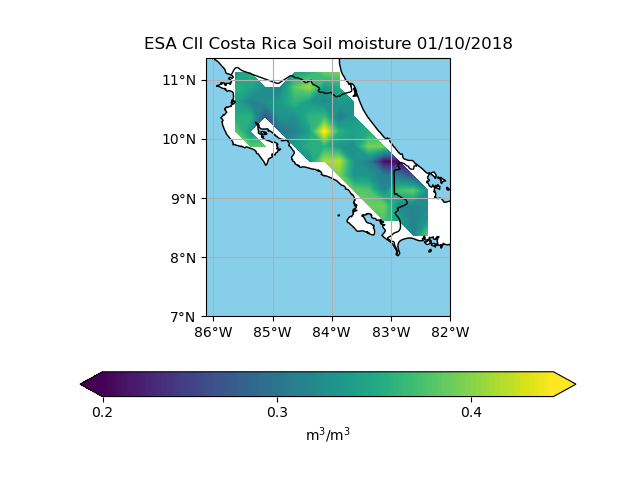

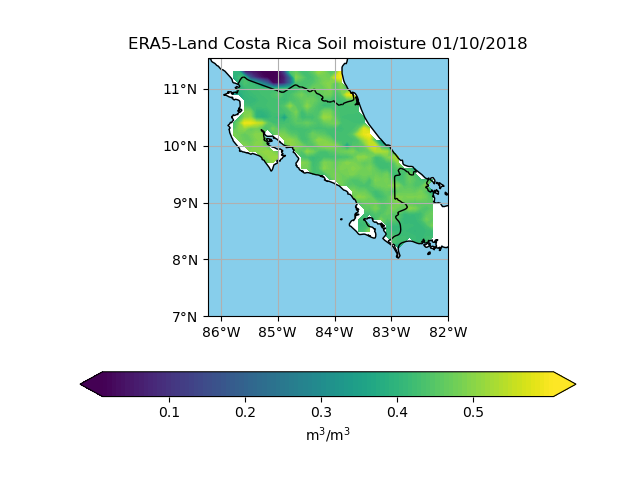

In [135]:
os.chdir(dirOutput)
x = Image(filename='costa_rica_soil_moistur_esa.png') 
y = Image(filename='costa_rica_soil_moistur_cop.png') 
display(x, y)

In [433]:

dirData + 'copernicus/costa_rica/'

'C:/Users/frenc/Desktop/SK enterprise/raincoat-takehome-science-main/data/copernicus/costa_rica'

In [38]:
import xarray as xr
import numpy as np
from scipy.interpolate import griddata

# Load the NetCDF files
file_path1 = dirData + 'copernicus/costa_rica/data.nc'
file_path2 = dirData + 'cerda2018/costa_rica_october2018.nc'

# Load both datasets using xarray
data1 = xr.open_dataset(file_path1)
data2 = xr.open_dataset(file_path2)

# Check the coordinates and resolutions of both datasets
print("Dataset 1:")
print(data1)
print("\nDataset 2:")
print(data2)

# Interpolate data2 onto data1's grid
points = np.column_stack([data2.lon.values.ravel(), data2.lat.values.ravel()])
values = data2.sm.values.ravel()

grid_x, grid_y = np.meshgrid(data1.longitude.values, data1.latitude.values)

# Create a regular grid for data1's coordinates
regular_grid = np.column_stack([grid_x.ravel(), grid_y.ravel()])

# Interpolate irregularly spaced data2 onto the regular grid of data1
interpolated_values = griddata(points, values, regular_grid, method='linear')

# Reshape the interpolated values back to the grid shape
interpolated_values = interpolated_values.reshape(grid_x.shape)

# Create a new xarray dataset with the interpolated values
data2_interpolated = xr.Dataset(
    {
        'sm': (['latitude', 'longitude'], interpolated_values)
    },
    coords={'latitude': data1.latitude, 'longitude': data1.longitude}
)

# Take the average of the two datasets to create a merged dataset
merged_data = (data1 + data2_interpolated) / 2

# Save the merged dataset to a new NetCDF file
merged_data.to_netcdf('merged_file.nc')

# Close the datasets
data1.close()
data2.close()


Dataset 1:
<xarray.Dataset>
Dimensions:    (longitude: 38, latitude: 36, time: 31)
Coordinates:
  * longitude  (longitude) float32 -85.98 -85.88 -85.78 ... -82.48 -82.38 -82.28
  * latitude   (latitude) float32 11.3 11.2 11.1 11.0 10.9 ... 8.1 8.0 7.9 7.8
  * time       (time) datetime64[ns] 2018-10-01T12:00:00 ... 2018-10-31T12:00:00
Data variables:
    swvl1      (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-11-17 10:33:04 GMT by grib_to_netcdf-2.24.0: /opt/ecmw...

Dataset 2:
<xarray.Dataset>
Dimensions:         (time: 31, lat: 14, lon: 15)
Coordinates:
  * time            (time) datetime64[ns] 2018-10-01 2018-10-02 ... 2018-10-31
  * lat             (lat) float64 11.12 10.88 10.62 10.38 ... 8.375 8.125 7.875
  * lon             (lon) float64 -85.88 -85.62 -85.38 ... -82.88 -82.62 -82.38
Data variables:
    sm              (time, lat, lon) float32 ...
    sm_uncertainty  (time, lat, lon) float32 ...
    flag            (time, lat

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 15 and the array at index 1 has size 14

# Time series building

In [425]:
os.chdir(dirData + 'cerda2018/')

# Load the NetCDF file using xarray
file_path = 'costa_rica_october2018.nc'
data = xr.open_dataset(file_path)

# Extract variables
sm = data['sm'].to_dataframe().reset_index(drop=True)

lat_data = data['lat'].to_dataframe()
lat_data = lat_data.reset_index(drop=True)
len_lat = lat_data.shape[0]

lon_data = data['lon'].to_dataframe()
lon_data = lon_data.reset_index(drop=True)
len_lon = lon_data.shape[0]

time_data = data['time'].to_dataframe()
time_data = time_data.reset_index(drop=True)
len_time = time_data.shape[0]

lat_rep = lat_data.loc[lat_data.index.repeat(len_lon*len_time)].reset_index(drop=True)

lon_rep = pd.concat([lon_data] * len_lat*len_time).reset_index(drop=True)

time_rep = time_data.loc[time_data.index.repeat(len_lat*len_lon)].reset_index(drop=True)

df_era = pd.concat([time_rep, lat_rep, lon_rep, sm], axis=1)

print(df_era)

print(df_era.shape)

df_era[["sm"]].describe(include ='all')

           time     lat     lon        sm
0    2018-10-01  11.125 -85.875       NaN
1    2018-10-01  11.125 -85.625  0.328799
2    2018-10-01  11.125 -85.375  0.360924
3    2018-10-01  11.125 -85.125       NaN
4    2018-10-01  11.125 -84.875       NaN
...         ...     ...     ...       ...
6505 2018-10-31   7.875 -83.375       NaN
6506 2018-10-31   7.875 -83.125       NaN
6507 2018-10-31   7.875 -82.875       NaN
6508 2018-10-31   7.875 -82.625       NaN
6509 2018-10-31   7.875 -82.375       NaN

[6510 rows x 4 columns]
(6510, 4)


,sm
count,2466.000000
mean,0.342349
std,0.039086
min,0.174269
25%,0.319091
50%,0.338424
75%,0.373439
max,0.444256


In [427]:
os.chdir(dirData + 'copernicus/costa_rica/')

# Load the NetCDF file using xarray
file_path = 'data.nc'
data = xr.open_dataset(file_path)

# Extract variables
sm = data['swvl1'].to_dataframe().reset_index(drop=True)

lat_data = data['latitude'].to_dataframe()
lat_data = lat_data.reset_index(drop=True)
len_lat = lat_data.shape[0]

lon_data = data['longitude'].to_dataframe()
lon_data = lon_data.reset_index(drop=True)
len_lon = lon_data.shape[0]

time_data = data['time'].to_dataframe()
time_data = time_data.reset_index(drop=True)
len_time = time_data.shape[0]

lat_rep = lat_data.loc[lat_data.index.repeat(len_lon*len_time)].reset_index(drop=True)

lon_rep = pd.concat([lon_data] * len_lat*len_time).reset_index(drop=True)

time_rep = time_data.loc[time_data.index.repeat(len_lat*len_lon)].reset_index(drop=True)

df_cop = pd.concat([time_rep, lat_rep, lon_rep, sm], axis=1)

print(df_cop)

print(df_cop.shape)

df_cop[["swvl1"]].describe()

                     time  latitude  longitude     swvl1
0     2018-10-01 12:00:00      11.3 -85.980003       NaN
1     2018-10-01 12:00:00      11.3 -85.879997       NaN
2     2018-10-01 12:00:00      11.3 -85.779999  0.409316
3     2018-10-01 12:00:00      11.3 -85.680000  0.387835
4     2018-10-01 12:00:00      11.3 -85.580002  0.055919
...                   ...       ...        ...       ...
42403 2018-10-31 12:00:00       7.8 -82.680000       NaN
42404 2018-10-31 12:00:00       7.8 -82.580002       NaN
42405 2018-10-31 12:00:00       7.8 -82.480003       NaN
42406 2018-10-31 12:00:00       7.8 -82.379997       NaN
42407 2018-10-31 12:00:00       7.8 -82.279999       NaN

[42408 rows x 4 columns]
(42408, 4)


,swvl1
count,17732.000000
mean,0.430145
std,0.083878
min,0.009995
25%,0.413430
50%,0.437101
75%,0.473272
max,0.613113


# GIF map

In [138]:
os.chdir(dirData + 'cerda2018/')

# Load the NetCDF file using xarray
file_path = 'costa_rica_october2018.nc'
data = xr.open_dataset(file_path)

# Extract soil moisture data
sm_data = data['sm']  # Assuming 'sm' is the soil moisture variable
os.chdir(dirOutput +'esa_costarica/')
days = np.arange(0, 31)


# Get the minimum and maximum values for normalization
sm_min = sm_data.min().values
sm_max = sm_data.max().values

# Create normalization for the color bar
norm = Normalize(vmin=sm_min, vmax=sm_max)

# Plotting the first time step 
for k in days:
    klab=k+1
    sm_at_time_step = sm_data.isel(time=k)
    
    # Creating the plot
    plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.gridlines()
    ax.set_xticks([-86,-85,-84,-83, -82], crs=ccrs.PlateCarree())
    ax.set_yticks([7,8,9,10,11], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    # Plotting the data on the map
    sm_plot = plt.pcolormesh(sm_at_time_step.coords['lon'], sm_at_time_step.coords['lat'], sm_at_time_step,
                             transform=ccrs.PlateCarree(), cmap='viridis', norm=norm)
    
    plt.colorbar(sm_plot, label='Soil Moisture m$^3$/m$^3$', ticks =[0.25,0.30,0.35,0.4])
    
    plt.title('Soil Moisture ' + str(klab) + '/10/2018')
    plt.savefig('costa_rica_soil_moistur_esa'+ str(k)+'.jpg')
    plt.clf()

image_frames = []

for k in days:
    new_frame = PIL.Image.open('costa_rica_soil_moistur_esa'+ str(k)+'.jpg')
    image_frames.append(new_frame)
    
image_frames[0].save('soilmoisture_costarica_era.gif', format = 'GIF', 
            append_images = image_frames[1: ], 
            save_all = True, duration = 200, 
            loop = 0)

C:\Users\frenc\AppData\Local\Temp\ipykernel_5800\1924119160.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [163]:
os.chdir(dirData + 'copernicus/costa_rica')

# Load the NetCDF file using xarray
file_path = 'data.nc'
data = xr.open_dataset(file_path)

# Extract soil moisture data
sm_data = data['swvl1']  # Assuming 'sm' is the soil moisture variable
os.chdir(dirOutput +'cop_costarica/')
days = np.arange(0, 31)


# Get the minimum and maximum values for normalization
sm_min = sm_data.min().values
sm_max = sm_data.max().values

# Create normalization for the color bar
norm = Normalize(vmin=sm_min, vmax=sm_max)

# Plotting the first time step 
for k in days:
    klab=k+1
    sm_at_time_step = sm_data.isel(time=k)
    
    # Creating the plot
    plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.gridlines()
    ax.set_xticks([-86,-85,-84,-83, -82], crs=ccrs.PlateCarree())
    ax.set_yticks([7,8,9,10,11], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    # Plotting the data on the map
    sm_plot = plt.pcolormesh(sm_at_time_step.coords['longitude'], sm_at_time_step.coords['latitude'], sm_at_time_step,
                             transform=ccrs.PlateCarree(), cmap='viridis', norm=norm)
    
    plt.colorbar(sm_plot, label='Soil Moisture m$^3$/m$^3$', ticks =[0.25,0.30,0.35,0.4])
    
    plt.title('Soil Moisture ' + str(klab) + '/10/2018')
    plt.savefig('costa_rica_soil_moistur_esa'+ str(k)+'.jpg')
    plt.clf()

image_frames = []

for k in days:
    new_frame = PIL.Image.open('costa_rica_soil_moistur_esa'+ str(k)+'.jpg')
    image_frames.append(new_frame)
    
image_frames[0].save('soilmoisture_costarica_era.gif', format = 'GIF', 
            append_images = image_frames[1: ], 
            save_all = True, duration = 200, 
            loop = 0)

C:\Users\frenc\AppData\Local\Temp\ipykernel_5800\4023356455.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

# References

1. Dorigo, W.A., Wagner, W., Albergel, C., Albrecht, F., Balsamo, G., Brocca, L., Chung, D., Ertl, M., Forkel, M., Gruber, A., Haas, E., Hamer, D. P. Hirschi, M., Ikonen, J., De Jeu, R. Kidd, R. Lahoz, W., Liu, Y.Y., Miralles, D., Lecomte, P. (2017). ESA CCI Soil Moisture for improved Earth system understanding: State-of-the art and future directions. In Remote Sensing of Environment, 2017, ISSN 0034-4257, https://doi.org/10.1016/j.rse.2017.07.001

2. Gruber, A., Scanlon, T., van der Schalie, R., Wagner, W., and Dorigo, W. (2019). Evolution of the ESA CCI Soil Moisture climate data records and their underlying merging methodology, Earth Syst. Sci. Data, 11, 717–739, https://doi.org/10.5194/essd-11-717-2019

3. Muñoz-Sabater J., Dutra E.,Agustí-Panareda A., Albergel C., Arduini G., Balsamo G., Thépaut J.N., et al. (2021). ERA5-Land: a state-of-the-art global reanalysis dataset for land applications, Earth Syst. Sci. Data, 13 (9), pp. 4349-4383, https://doi.org/10.5194/essd-13-4349-2021
